In [2]:
!pip install scratchai-nightly  
!pip install torchvision==0.9.1 
!pip install flashtorch         
!pip install mapextrackt        
!pip install tqdm
!pip install requests
!pip install opencv-python
!pip install scipy

     ---------------------------------------- 87.2/87.2 kB 5.1 MB/s eta 0:00:00
     ------------------------------------- 852.3/852.3 kB 13.4 MB/s eta 0:00:00
     ------------------------------------- 190.5/190.5 MB 13.3 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 54.9 MB/s eta 0:00:00
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 7.2/7.2 MB 21.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
     ------------------------------------- 965.4/965.4 kB 29.8 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26245 sha256=014f40b599a00d76fa6ef46d52f1dc3ab2c7b9071f22e37c8bb350bfc35a584f
  Stored in d

In [1]:
# download and store locally a stop sign image
stop_sign_url = 'https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg'
!mkdir input_images
!wget https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg -O input_images/stop.jpg

A subdirectory or file input_images already exists.
--2024-01-25 09:29:58--  https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 146.75.29.164
Connecting to static01.nyt.com (static01.nyt.com)|146.75.29.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92066 (90K) [image/jpeg]
Saving to: 'input_images/stop.jpg'

     0K .......... .......... .......... .......... .......... 55% 3.59M 0s
    50K .......... .......... .......... .........            100% 15.6M=0.02s

2024-01-25 09:29:58 (5.46 MB/s) - 'input_images/stop.jpg' saved [92066/92066]



In [1]:
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize)

# import the library
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from scratchai import *

from flashtorch.activmax import GradientAscent
from MapExtrackt import FeatureExtractor
from torch.distributions import Normal

from tqdm import tqdm


# set parameters
stop_sign_path = 'input_images/stop.jpg' #stop sign image path
true_class = 919 # imagenet id for street sign


# function handle to get prediction more easily
def get_prediction(image, model):
    #assumes img and net are datasets and models trained using imagenet dataset
    confidences = model(image.unsqueeze(0))
    class_idx = torch.argmax(confidences, dim=1).item()
    class_label = datasets.labels.imagenet_labels[class_idx]
    return class_label, confidences[0, class_idx].item(), class_idx

c:\Users\amanc\anaconda3\envs\TAI_24784\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1a: Making prediction**

In [2]:
# load and preprocess the stop sign image
img = imgutils.load_img(stop_sign_path)
img = imgutils.get_trf('rz256_cc224_tt_normimgnet')(img) #normalize and reshape the input image

# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval()  # load resnet

# use the provided get_prediction function to predict the class of the stop sign image
class_label, confidence, class_idx = get_prediction(img, net)
print('Predicted class: {} (confidence: {:.2f})'.format(class_label, confidence))

Predicted class: street sign (confidence: 13.56)


Comments: 

**1b: Random perturbation**

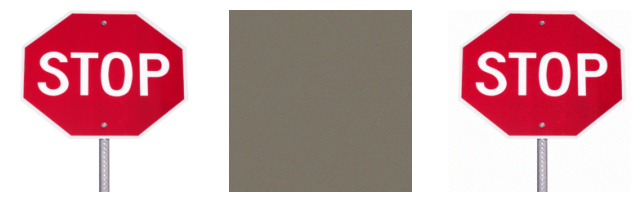

Prediction: street sign, Confidence: 14.59, Label_id: 919


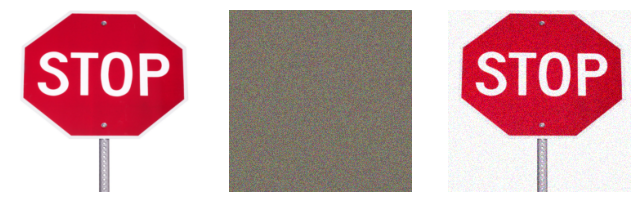

Prediction: doormat, welcome mat, Confidence: 14.96, Label_id: 539


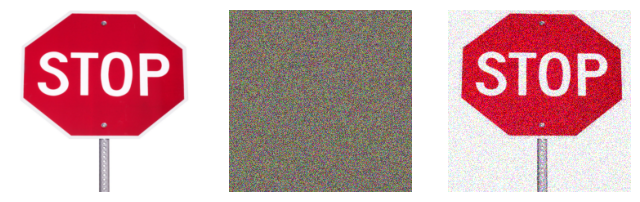

Prediction: doormat, welcome mat, Confidence: 16.60, Label_id: 539


In [3]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilons = [0.1, 0.5, 1] # set the epsilon

for epsilon in epsilons:
    torch.manual_seed(0) # set the random seed when you use functions that uses sampling

    noisy_img = attacks.noise(img, eps=epsilon) # perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

    # output prediction, conf, and label_id using get_prediction function
    class_label, confidence, class_idx = get_prediction(noisy_img, net)

    imgutils.imshow([img, noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image

    print('Prediction: %s, Confidence: %.2f, Label_id: %d' % (class_label, confidence, class_idx))

Comments:

**1c: FGM Attack**

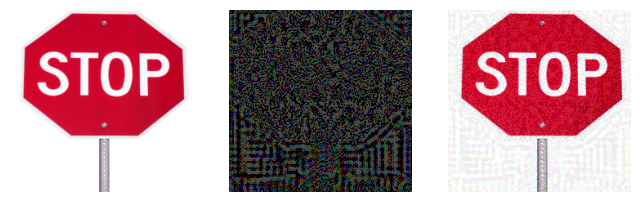

(('street sign', 13.558080673217773),
 ('doormat, welcome mat', 14.294462203979492))

In [4]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
img_path = "input_images/stop.jpg" # stop sign image path
images, true_labels, predicted_labels = one_call.attack(img_path, atk=attacks.FGM, nstr='resnet18', ret=True) # perform FGM attacks and return all the outputs

imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels # show true and predicted labels

Comments:

**1d: PGD Attack**

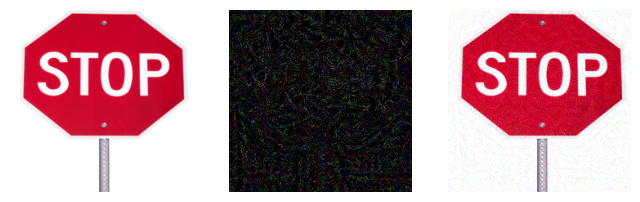

(('street sign', 13.558080673217773),
 ('jersey, T-shirt, tee shirt', 47.742530822753906))

In [5]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

target_class = 829 # imagenet id for street car

img_path = "input_images/stop.jpg" # stop sign image path
images, true_labels, predicted_labels = one_call.attack(img_path, atk=attacks.PGD, nstr='resnet18', ret=True) # perform PGD attacks and return all the outputs

imgutils.imshow(images) # show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels #show true and predicted labels

Comments:

**2a: AlexNet layer 0 visualization**

In [6]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

model = models.alexnet(pretrained=True).eval()  #load pretrained alexnet

print(model) #show the alexnet structure

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

c:\Users\amanc\anaconda3\envs\TAI_24784\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


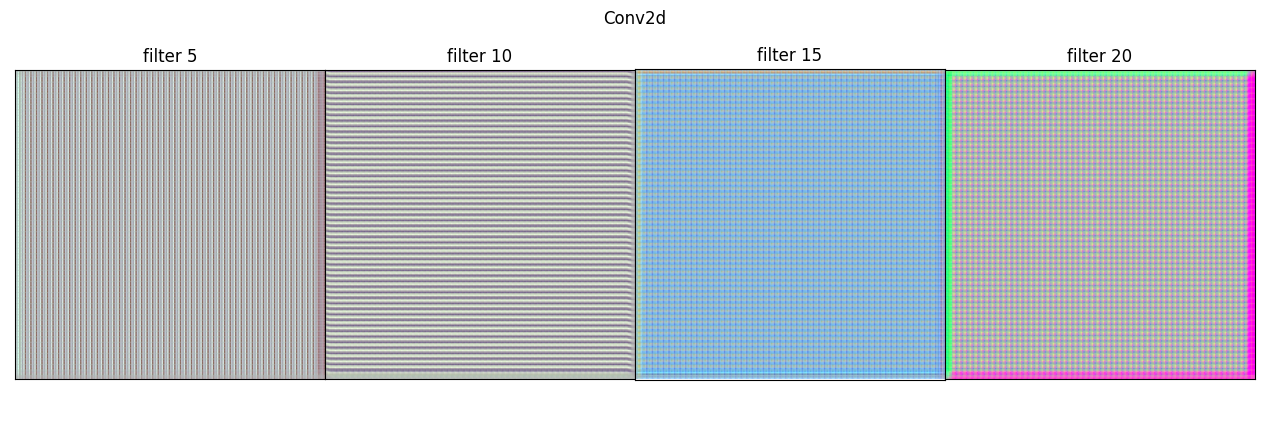

In [7]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = 0 # set the layer index

filters = [5, 10, 15, 20] # set the filter numbers

layer = model.features[layer_idx] # select the 1st conv layer

# call g_ascent.visualize() with the correct arguments to output the visualization
g_ascent.visualize(layer, filters)


**2b: AlexNet layer 10 visualization**

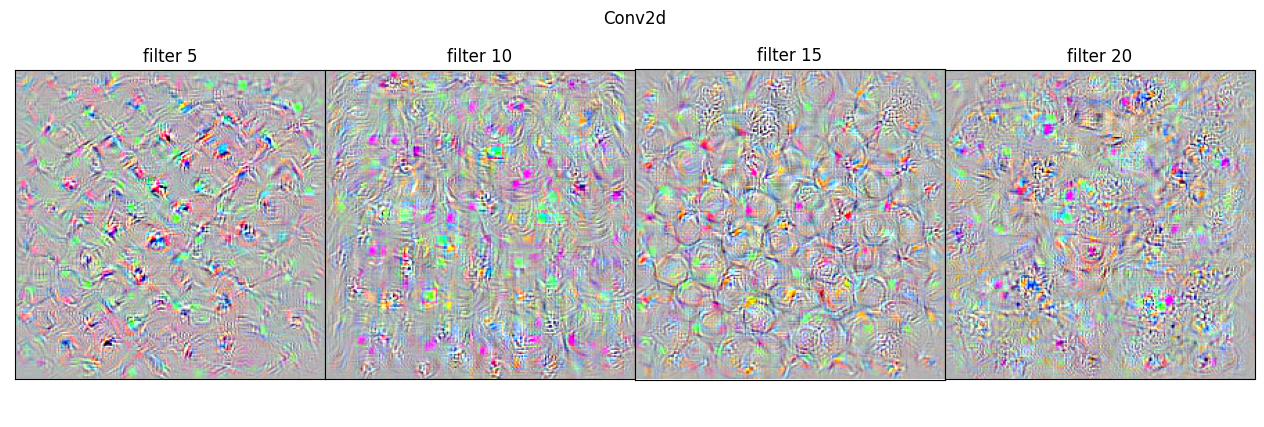

In [8]:
# MODIFY THE CODE FOR 2a TO VISUALIZE LAYER 10, FILTERS [5, 10, 15, 20] OF ALEXNET
layer_idx = 10 # set the layer index

filters = [5, 10, 15, 20] # set the filter numbers

layer = model.features[layer_idx] # select the 1st conv layer

# call g_ascent.visualize() with the correct arguments to output the visualization
g_ascent.visualize(layer, filters)


**2c: AlexNet saliency map with the stop sign image**

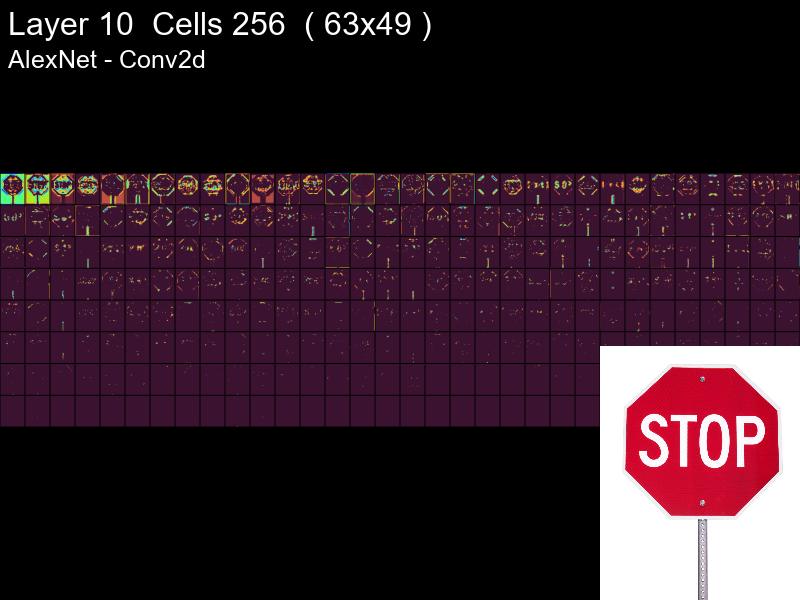

In [9]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# load FeatureExtractor
from MapExtrackt import FeatureExtractor

layer_idx = 10 #define the layer index

fe = FeatureExtractor(model)

fe.set_image(stop_sign_path) # stop_sign_path is the path to the stop sign image

fe.display_from_map(layer_no=layer_idx)

**3: Example of plot with a confidence interval**



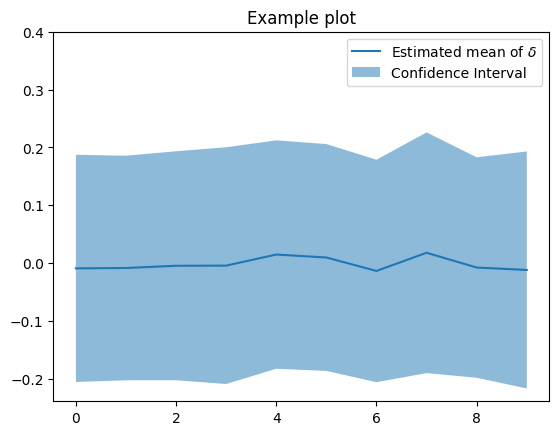

In [10]:
#THIS IS JUST AN EXAMPLE TO PLOT CONFIDENCE INTERVAL AS SHADED AREA

n = 500 # number of samples
k = 10  # number of replications
sigma = 0.2

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(n, k)) # gaussian samples ~ N(0, sigma*I)

# compute mean and standard deviation
mean_ = deltas.mean(dim=0)
std_ = deltas.std(dim=0)

# generate the plot
x = np.arange(k) # populate x axis
plt.plot(x, mean_, label="Estimated mean of $\delta$")
plt.fill_between(x, mean_ - std_, mean_ + std_, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.4])
plt.title('Example plot')
plt.show()

**Density computation example with log_prob**

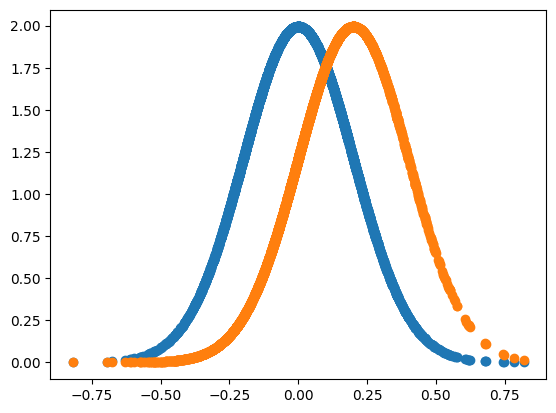

In [11]:
# THIS IS AN EXAMPLE TO USE log_prob METHOD FOR EASIER DENSITY COMPUTATION

# Suppose you want to compute the density of Normal distribution

# create Normal distribution object
p = Normal(torch.tensor([0.0]), torch.tensor([sigma]))       # N(0, sigma**2)
p_tilde = Normal(torch.tensor([0.2]), torch.tensor([sigma])) # N(1, sigma**2)

# use log_prob method
log_density_orig = p.log_prob(deltas) # log_prob method gives you log densities
log_density_tilde = p_tilde.log_prob(deltas)

# verify this by plotting the density, i.e. the exp of the log_density
plt.scatter(deltas, torch.exp(log_density_orig), label="p")
plt.scatter(deltas, torch.exp(log_density_tilde), label="p_tilde")
plt.show()

**3a: MC estimator for prob. robustness of ResNet-18**

In [12]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval() # load resnet

import math
sigma = 0.2 # parameter sigma

# evaluate the model k times, each time use n samples
k = 10 # number of replications
n = 50 # number of samples in each replication

# collect the samples
torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma*I)

resnet_test=np.zeros([n, k])

for i in tqdm(range(k)):
    for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [13]:
# compute the mean and standard deviation of your estimator
mu_hat_n_samples = resnet_test.mean(axis=0)

mean_ = mu_hat_n_samples.mean()
std_ = mu_hat_n_samples.std()

mean_, std_

(0.04, 0.029664793948382652)

In [14]:
# REPEAT THE ABOVE EXAMPLE FOR n = [100, ..., 1000]
# evaluate the model k times, each time use n samples

k = 10 # number of replications

mean = []
std = []

for n in range(50, 550, 50):
    print("Number of samples: "+str(n))
    # collect the samples
    torch.manual_seed(0) # set the random seed
    deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma*I)

    resnet_test=np.zeros([n, k])

    for i in tqdm(range(k)):
        for j in range(n):
            noisy_img = img + deltas[:, :, :, j, i]
            _, _, y_i = get_prediction(noisy_img, net)
            resnet_test[j, i] = y_i != true_class
    
    mu_hat_n_samples = resnet_test.mean(axis=0)

    mean_ = mu_hat_n_samples.mean()
    std_ = mu_hat_n_samples.std()
    print(f"Mean: {mean_}, Std: {std_} \n")
    mean.append(mean_)
    std.append(std_)


Number of samples: 50


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Mean: 0.04, Std: 0.029664793948382652 

Number of samples: 100


100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


Mean: 0.030000000000000006, Std: 0.0161245154965971 

Number of samples: 150


100%|██████████| 10/10 [01:34<00:00,  9.46s/it]


Mean: 0.024, Std: 0.00679869268479038 

Number of samples: 200


100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


Mean: 0.03400000000000001, Std: 0.010198039027185569 

Number of samples: 250


100%|██████████| 10/10 [02:19<00:00, 13.97s/it]


Mean: 0.028000000000000004, Std: 0.010430723848324237 

Number of samples: 300


100%|██████████| 10/10 [02:47<00:00, 16.73s/it]


Mean: 0.03, Std: 0.01043498389499902 

Number of samples: 350


100%|██████████| 10/10 [02:19<00:00, 13.91s/it]


Mean: 0.028000000000000004, Std: 0.008161632489763258 

Number of samples: 400


100%|██████████| 10/10 [02:39<00:00, 15.97s/it]


Mean: 0.026749999999999996, Std: 0.00698659430624106 

Number of samples: 450


100%|██████████| 10/10 [03:03<00:00, 18.38s/it]


Mean: 0.03, Std: 0.008620962107231477 

Number of samples: 500


100%|██████████| 10/10 [03:25<00:00, 20.55s/it]

Mean: 0.03380000000000001, Std: 0.0066 



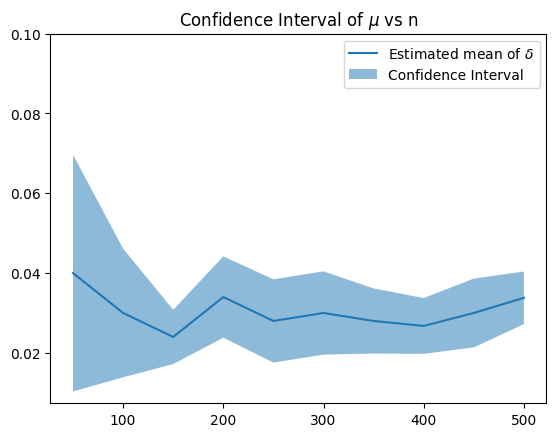

In [19]:
# PLOT THE MEAN AND THE CONFIDENCE INTERVAL OF THE k VALUES OF mu_hat_n VS n
# generate the plot
x = list(range(50, 550, 50)) # populate x axis
plt.plot(x, mean, label="Estimated mean of $\delta$")
minlim = np.array(mean) - np.array(std)
maxlim = np.array(mean) + np.array(std)
plt.fill_between(x, minlim, maxlim, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.1])
plt.title('Confidence Interval of $\mu$ vs n')
plt.show()

**3b: MC relative error**

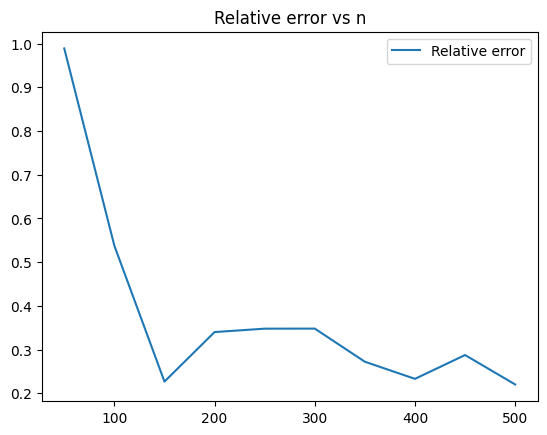

In [23]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

mu = 0.03 #true mu value

# compute the relative error
relative_egiven = [std_i/mu for std_i in std]

# PLOT THE RELATIVE ERROR VS n
# generate the plot
x = list(range(50, 550, 50)) # populate x axis
plt.plot(x, relative_egiven, label="Relative error")
plt.legend()
plt.title('Relative error vs n')
plt.show()


**3c: Misclassification rate w.r.t. samples close to an adversarial example**

In [28]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# repeat the FGM attack from problem 1c
img_path = "input_images/stop.jpg" # stop sign image path
images, true_labels, predicted_labels = one_call.attack(img_path, atk=attacks.FGM, nstr='resnet18', ret=True) # perform FGM attacks and return all the outputs
xtilde = images[2]

# perform mean shift, closer to the adversarial example
scale = 1/3
mean_shift = scale*xtilde

mean = []
std = []
# compute misclassification rate using this new deltas, similar to 3a above
for n in range(50, 550, 50):
    print("Number of samples: "+str(n))
    # generate Gaussian samples centered at the mean_shift
    torch.manual_seed(0) # set the random seed
    deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(1/3 xtilde, sigma*I)
    deltas = deltas + mean_shift.unsqueeze(-1).unsqueeze(-1)

    resnet_test=np.zeros([n, k])

    for i in tqdm(range(k)):
        for j in range(n):
            noisy_img = img + deltas[:, :, :, j, i]
            _, _, y_i = get_prediction(noisy_img, net)
            resnet_test[j, i] = y_i != true_class
    
    mu_hat_n_samples = resnet_test.mean(axis=0)

    mean_ = mu_hat_n_samples.mean()
    std_ = mu_hat_n_samples.std()
    print(f"Mean: {mean_}, Std: {std_} \n")
    mean.append(mean_)
    std.append(std_)


Number of samples: 50


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Mean: 0.492, Std: 0.07386474125047755 

Number of samples: 100


100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


Mean: 0.5030000000000001, Std: 0.042673176586703755 

Number of samples: 150


100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


Mean: 0.4713333333333334, Std: 0.04676655975278821 

Number of samples: 200


100%|██████████| 10/10 [01:36<00:00,  9.68s/it]


Mean: 0.5, Std: 0.03405877273185282 

Number of samples: 250


100%|██████████| 10/10 [02:00<00:00, 12.06s/it]


Mean: 0.49559999999999993, Std: 0.03085190431723787 

Number of samples: 300


100%|██████████| 10/10 [02:24<00:00, 14.45s/it]


Mean: 0.49399999999999994, Std: 0.027357712704910914 

Number of samples: 350


100%|██████████| 10/10 [02:48<00:00, 16.80s/it]


Mean: 0.47685714285714287, Std: 0.030571428571428572 

Number of samples: 400


100%|██████████| 10/10 [03:15<00:00, 19.51s/it]


Mean: 0.47350000000000003, Std: 0.034263683398023624 

Number of samples: 450


100%|██████████| 10/10 [03:40<00:00, 22.04s/it]


Mean: 0.4724444444444444, Std: 0.024689678955255378 

Number of samples: 500


100%|██████████| 10/10 [04:10<00:00, 25.09s/it]

Mean: 0.4904, Std: 0.02559374923687423 



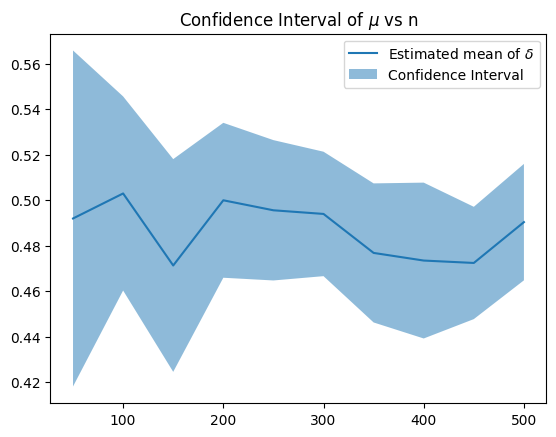

In [31]:
# generate the plot
x = list(range(50, 550, 50)) # populate x axis
plt.plot(x, mean, label="Estimated mean of $\delta$")
minlim = np.array(mean) - np.array(std)
maxlim = np.array(mean) + np.array(std)
plt.fill_between(x, minlim, maxlim, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
# plt.ylim([None, 0.1])
plt.title('Confidence Interval of $\mu$ vs n')
plt.show()